In [1]:
import regex
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import morfeusz2
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from spacy.tokenizer import Tokenizer
from nlp_common.acts_reader import ActsReader
from collections import Counter
from itertools import chain

### Data preparation

Data used in the exercise comes from two sources: set of polish bills (from previous exercies) and sgjp dictionary. The second one is loaded to elasticsearch in the attached script (main.py).

In [2]:
acts_reader = ActsReader('../ustawy') 
bills = [ text for _, _, text in acts_reader.all_acts()]

### Remove HTML tags

In [3]:
html_regex = regex.compile(r'<\/?[^>]*>', regex.IGNORECASE)
for bill in bills:
    matches = html_regex.findall(bill)
    for match in matches:
        print(match)

< < tajne >


Nothing to clean 🤷

### Tokenize

In [4]:
new_line_re = regex.compile(r'\n+')
bills = [new_line_re.sub(' ', bill) for bill in bills]

In [5]:
nlp = spacy.load("pl_core_news_sm")
prefix_re = regex.compile(r'''^[\[\("'\„]''')
suffix_re = regex.compile(r'''[\]\)"'\:\;\,\.]+$''')
nlp.tokenizer = Tokenizer(nlp.vocab, prefix_search=prefix_re.search, suffix_search=suffix_re.search)

In [6]:
bill_docs = list(nlp.tokenizer.pipe(bills))

### Word counters

In [7]:
ctrs = [ Counter([d.text.lower() for d in doc]) for doc in bill_docs ]

In [8]:
global_counter = Counter()
for ctr in ctrs:
    global_counter += ctr

In [9]:
len(global_counter)

72507

### Rank

In [10]:
# Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).
def reject(word):
    if len(word) < 2 or not regex.match(r'^\p{L}+$', word):
        return True
    return False

word_ctr_pairs = [ (word, global_counter[word]) for word in global_counter ]
word_ctr_pairs_without_rejected = filter(lambda w: not reject(w[0]), word_ctr_pairs)
word_ctr_pairs_sorted = sorted(word_ctr_pairs_without_rejected, key=lambda w: (-w[1], w[0]))
word_ctr_pairs_ranked = map(lambda wi: (wi[1][0], wi[1][1], wi[0]+1), enumerate(word_ctr_pairs_sorted))
df = pd.DataFrame(word_ctr_pairs_ranked, columns=['word', '#occurences', 'rank'])

In [11]:
df

,word,#occurences,rank
0,art,83586,1
1,do,60724,2
2,ust,53367,3
3,na,50639,4
4,się,45864,5
...,...,...,...
54334,żądanego,1,54335
54335,żądaniami,1,54336
54336,żądano,1,54337
54337,żądany,1,54338


### Plot

<AxesSubplot:xlabel='rank', ylabel='#occurences'>

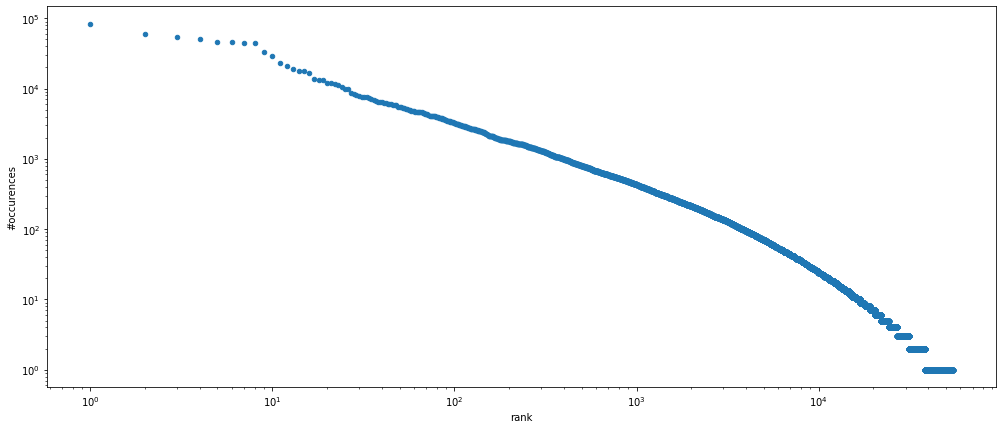

In [12]:
df.plot.scatter(x='rank', y='#occurences', logx=True, logy=True, figsize=(17,7))

### Words that not appear in dictionary

In [13]:
morf = morfeusz2.Morfeusz()
df['in_morfeusz'] = df['word'].apply(lambda x: morf.analyse(x)[0][2][2] != 'ign')

#### Top 30 words with the highest ranks that do not belong to the dictionary

In [14]:
top_unknown_df = df[df['in_morfeusz'] == False][:30]
top_unknown_df

,word,#occurences,rank,in_morfeusz
6,poz,45009,7,False
367,późn,1065,368,False
830,str,514,831,False
1427,gmo,298,1428,False
2018,sww,211,2019,False
2196,skw,193,2197,False
2479,ex,167,2480,False
2551,ike,162,2552,False
3347,remediacji,119,3348,False
3502,zm,112,3503,False


#### 30 random words (i.e. shuffle the words) with 3-7 occurrences that do not belong to the dictionary.

In [15]:
random_unknown_df = df[(df['in_morfeusz'] == False) & (df['#occurences'] >= 3) & (df['#occurences'] <= 7)].sample(n=30)
random_unknown_df

,word,#occurences,rank,in_morfeusz
22066,ami,5,22067,False
30136,trifenyle,3,30137,False
28072,krśt,3,28073,False
29271,produ,3,29272,False
30157,tuberculosis,3,30158,False
29125,postac,3,29126,False
26840,zan,4,26841,False
22427,jed,5,22428,False
27175,auditorów,3,27176,False
28322,mycoplasma,3,28323,False


### Finding closest word with Levenshtein metric

In [16]:
A = 'aąbcćdeęfghijklłmnńoóprsśtuwyzżź'

def generate_additions(word):
    for i in range(len(word)):
        for a in A:
            yield word[:i] + a + word[i:]

def generate_deletions(word):
    for i in range(len(word)):
        yield word[:i] + word[i+1:]
    
def generate_swaps(word):
    for i in range(len(word)):
        for a in A:
            if a != word[i]:
                yield word[:i] + a + word[i+1:]
    
def check_in_morf(word):
    return morf.analyse(word)[0][2][2] != 'ign'
    
def find_closest(word, max_d=2):
    # bfs
    Q = [(word, 0)]
    vis = { word }

    while len(Q) > 0:
        w, d = Q.pop(0)
        for wa in chain(generate_additions(w), generate_deletions(w), generate_swaps(w)):
            if check_in_morf(wa):
                return wa
            if not wa in vis and d < max_d:
                Q.append((wa, d+1))
                vis.add(wa)
    
    return None


find_closest('rytorialnego')

'terytorialnego'

In [ ]:
top_unknown_df['possible_correction'] = top_unknown_df['word'].apply(lambda x: find_closest(x))
random_unknown_df['possible_correction'] = random_unknown_df['word'].apply(lambda x: find_closest(x))

In [ ]:
top_unknown_df

In [ ]:
random_unknown_df

### Elastic search fuziness

In [ ]:
client = Elasticsearch("http://localhost:9200")

In [ ]:
def find_closest_elastic(word):
    s = Search(using=client, index="sgjp")\
        .query('match', word = { 'query': word, 'fuzziness': 2 })   

    response = s.execute()

    if len(response) == 0:
        return None
    return response[0].word

find_closest_elastic('rytorialnego')

In [ ]:
top_unknown_df['possible_correction_elastic'] = top_unknown_df['word'].apply(lambda x: find_closest_elastic(x))
random_unknown_df['possible_correction_elastic'] = random_unknown_df['word'].apply(lambda x: find_closest_elastic(x))

In [ ]:
top_unknown_df

In [ ]:
random_unknown_df